# DEMO 2

Logistic Regression applied to Stock Market Data


In [1]:
import sys
import os

# Manually set the path relative to the py file's location that you want to import
func_lib_path = os.path.abspath(os.path.join(os.getcwd(), '../'))# Add the path to sys.path
sys.path.append(func_lib_path)

# Now you can import func_lib
import func_lib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [ ]:
historical_prices = func_lib.createHistPrices()
list_of_momentums = [1, 5, 15, 20]
total_returns     = func_lib.computingReturns(historical_prices, list_of_momentums)
total_returns.dropna(inplace=True)

In [5]:
total_returns.head()

F_1_d_returns  1_d_returns  5_d_returns  15_d_returns  \
Ticker Date                                                                
A      2000-02-01       0.077465     0.072710     0.048938      0.029918   
       2000-02-02       0.016340     0.077465     0.119854      0.125000   
       2000-02-03      -0.019293     0.016340     0.136073      0.166980   
       2000-02-04       0.042623    -0.019293     0.120294      0.127542   
       2000-02-07      -0.006289     0.042623     0.201133      0.162706   

                   20_d_returns  
Ticker Date                      
A      2000-02-01     -0.013889  
       2000-02-02      0.150376  
       2000-02-03      0.246493  
       2000-02-04      0.270833  
       2000-02-07      0.223077

In [6]:
# Converting the 'F_1_d_returns' to binary based on whether the value is positive or not
total_returns['F_1_d_returns_Ind'] = total_returns['F_1_d_returns'].apply(lambda x: 1 if x > 0 else 0)
total_returns.head()

F_1_d_returns  1_d_returns  5_d_returns  15_d_returns  \
Ticker Date                                                                
A      2000-02-01       0.077465     0.072710     0.048938      0.029918   
       2000-02-02       0.016340     0.077465     0.119854      0.125000   
       2000-02-03      -0.019293     0.016340     0.136073      0.166980   
       2000-02-04       0.042623    -0.019293     0.120294      0.127542   
       2000-02-07      -0.006289     0.042623     0.201133      0.162706   

                   20_d_returns  F_1_d_returns_Ind  
Ticker Date                                         
A      2000-02-01     -0.013889                  1  
       2000-02-02      0.150376                  1  
       2000-02-03      0.246493                  0  
       2000-02-04      0.270833                  1  
       2000-02-07      0.223077                  0

In [7]:
# Determine the split index for 70% of the dates
unique_dates = total_returns.index.get_level_values('Date').unique()
split_date = unique_dates[int(0.7 * len(unique_dates))]
split_date

Timestamp('2017-01-20 00:00:00')

In [8]:
# Create the training set: all data before the split date
train_data = total_returns.loc[total_returns.index.get_level_values('Date') < split_date]

# Create the testing set: all data from the split date onwards
test_data = total_returns.loc[total_returns.index.get_level_values('Date') >= split_date]

In [9]:
total_returns  = test_data['F_1_d_returns']

In [10]:
features = ['1_d_returns', '5_d_returns', '15_d_returns', '20_d_returns']
target   = ['F_1_d_returns_Ind']

# Split the data into training and testing sets
X_train = train_data[features]
X_test  = test_data[features]
y_train = train_data[target]
y_test  = test_data[target]

In [11]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [12]:
# Add a constant to the model (intercept)
X_train_scaled_const_add = sm.add_constant(X_train_scaled)
X_test_scaled_const_add  = sm.add_constant(X_test_scaled)

# Fit the model
# Creating and fitting the logistic regression model
model = sm.Logit(y_train, X_train_scaled_const_add).fit()

# Print the model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.692570
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      F_1_d_returns_Ind   No. Observations:              1795319
Model:                          Logit   Df Residuals:                  1795314
Method:                           MLE   Df Model:                            4
Date:                Sun, 25 Aug 2024   Pseudo R-squ.:               0.0006056
Time:                        21:55:37   Log-Likelihood:            -1.2434e+06
converged:                       True   LL-Null:                   -1.2441e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0355      0.001     23.798      0.000       0.033       0.038
1_d_returns     -0.0288

In [13]:
model_name = 'Log'
# Make predictions
y_pred = model.predict(X_test_scaled_const_add)

y_test_df = pd.DataFrame(y_test)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.rename(columns={0:model_name}, inplace=True)

y_test_and_pred = pd.merge(y_pred_df, total_returns, left_index=True, right_index=True)

In [14]:
# Define trading strategy based on Logit
def trading_strategy(y_pred):
    if y_pred >0.5:
        return  1 # Go long
    else:
        return  0  


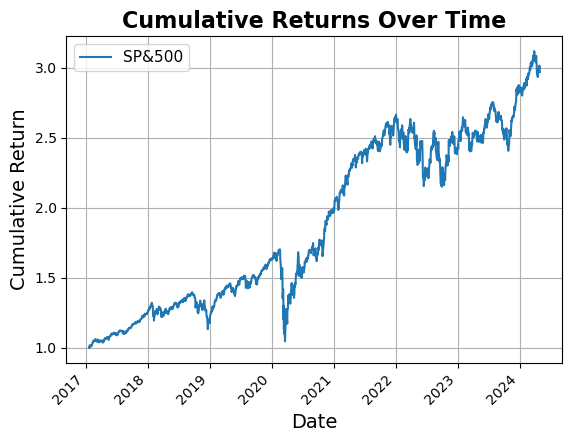

The CAGR is: 16.05%
Sharpe Ratio of Strategy: 0.85


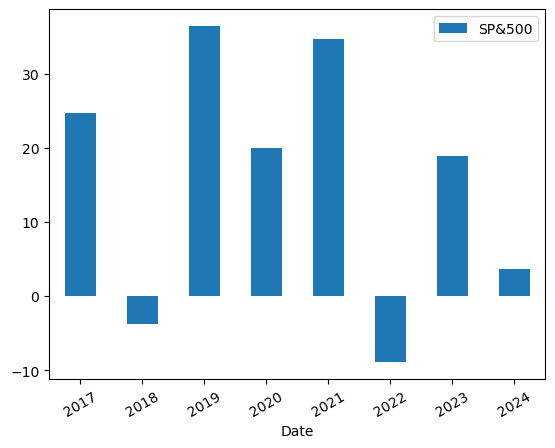

In [15]:
cum_returns, calendar_returns = func_lib.compute_BM_Perf(y_test_and_pred)

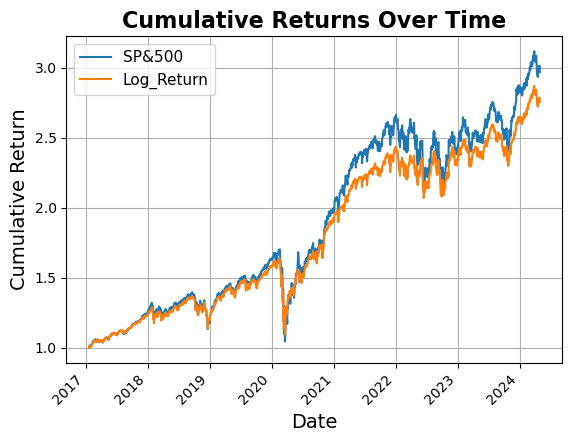

The CAGR is: 14.86%
Sharpe Ratio of Strategy: 0.9


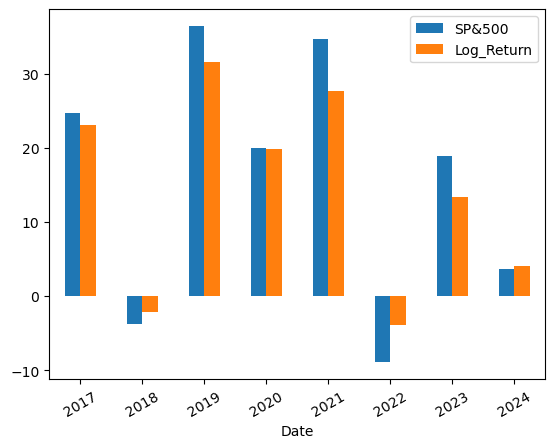

In [16]:
cum_returns, calendar_returns = func_lib.compute_strat_perf(y_test_and_pred, cum_returns, calendar_returns, trading_strategy, model_name)